In [12]:
from maskRCNN.pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from maskRCNN import visualize_815 as visualize
import torch
from maskRCNN import coco as cocomask
from maskRCNN import model_feats as modellib
import torch.nn as nn
import torch.utils.data as data
import pickle
import os

In [10]:
EPIC_MODEL_PATH = '/vision2/u/cy3/exp/rcnn/0819/coco20180820T0146/mask_rcnn_coco_0034.pth'
EPIC_ANNO_PATH = '/vision2/u/cy3/data/EPIC/annotations/EPIC_train_action_labels.csv'
ORN_MASK_PATH = '/vision2/u/cy3/data/mask-AR/masks_v2_for_AR_100x100_50/train'

In [52]:
class_names = ["BG", "Nothing", "pan", "pan:dust", "tap", "plate", "knife", "bowl", "spoon", "cupboard", "drawer",
               "fridge", "lid", "hand", "onion", "onion:spring", "pot", "glass", "water", "fork", "board:chopping",
               "bag", "sponge", "spatula", "cup", "oil", "bin", "meat", "potato", "bottle", "container",
               "tomato", "salt", "cloth", "sink", "door:kitchen", "pasta", "dish:soap", "food", "kettle", "box",
               "carrot", "sauce", "colander", "milk", "rice", "garlic", "pepper", "hob", "dough", "dishwasher",
               "egg", "cheese", "bread", "table", "salad", "microwave", "oven", "cooker:slow", "coffee", "filter",
               "jar", "rack:drying", "chicken", "tray", "mixture", "towel", "towel:kitchen", "peach", "skin",
               "courgette",
               "liquid:washing", "liquid", "leaf", "lettuce", "leaf:mint", "cutlery", "scissors", "package", "top",
               "spice",
               "tortilla", "paper", "machine:washing", "olive", "sausage", "glove:oven", "peeler:potato", "can", "mat",
               "mat:sushi",
               "vegetable", "wrap:plastic", "wrap", "flour", "cucumber", "curry", "cereal", "napkin", "soap", "squash",
               "fish", "chilli", "cover", "sugar", "aubergine", "jug", "heat", "leek", "rubbish", "ladle",
               "mushroom", "stock", "freezer", "light", "pizza", "ball", "yoghurt", "chopstick", "grape", "ginger",
               "banana", "oregano", "tuna", "kitchen", "salmon", "basket", "maker:coffee", "roll", "brush", "lemon",
               "clothes", "grater", "strainer", "bacon", "avocado", "blueberry", "pesto", "utensil", "bean:green",
               "floor",
               "lime", "foil", "grill", "ingredient", "scale", "paste:garlic", "processor:food", "nut:pine", "butter",
               "butter:peanut",
               "shelf", "timer", "rinse", "tablecloth", "switch", "powder:coconut", "powder:washing", "capsule", "oat",
               "tofu",
               "lighter", "corn", "vinegar", "grinder", "cap", "support", "cream", "content", "tongs", "pie",
               "fan:extractor", "raisin", "toaster", "broccoli", "pin:rolling", "plug", "button", "tea", "parsley",
               "flame",
               "herb", "base", "holder:filter", "thyme", "honey", "celery", "kiwi", "tissue", "time", "clip",
               "noodle", "yeast", "hummus", "coconut", "cabbage", "spinach", "nutella", "fruit", "dressing:salad",
               "omelette",
               "kale", "paella", "chip", "opener:bottle", "shirt", "chair", "sandwich", "burger:tuna", "pancake",
               "leftover",
               "risotto", "pestle", "sock", "pea", "apron", "juice", "wine", "dust", "desk", "mesh",
               "oatmeal", "artichoke", "remover:spot", "coriander", "mocha", "quorn", "soup", "turmeric", "knob",
               "seed",
               "boxer", "paprika", "juicer:lime", "guard:hand", "apple", "tahini", "finger", "salami", "mayonnaise",
               "biscuit",
               "pear", "mortar", "berry", "beef", "squeezer:lime", "tail", "stick:crab", "supplement", "phone",
               "shell:egg",
               "pith", "ring:onion", "cherry", "cake", "sprout", "almond", "mint", "flake:chilli", "cutter:pizza",
               "nesquik",
               "blender", "scrap", "backpack", "melon", "breadcrumb", "sticker", "shrimp", "smoothie", "grass:lemon",
               "ketchup",
               "slicer", "stand", "dumpling", "watch", "beer", "power", "heater", "basil", "cinnamon", "crisp",
               "asparagus", "drink", "fishcakes", "mustard", "caper", "whetstone", "candle", "control:remote",
               "instruction", "cork",
               "tab", "masher", "part", "muffin", "shaker:pepper", "garni:bouquet", "popcorn", "envelope", "chocolate",
               "spot",
               "window", "syrup", "bar:cereal", "croissant", "coke", "stereo", "alarm", "recipe", "handle", "sleeve",
               "cumin", "wire", "label", "fire", "presser", "air", "mouse", "boiler", "rest", "tablet",
               "poster", "trousers", "form", "rubber", "rug", "sheets", "pepper:cayenne", "waffle", "pineapple",
               "turkey",
               "alcohol", "rosemary", "lead", "book", "rim", "gravy", "straw", "hat", "cd", "slipper",
               "casserole", "ladder", "jambalaya", "wall", "tube", "lamp", "tarragon", "heart", "funnel", "whisk",
               "driver:screw", "trouser"]

In [4]:
class InferenceConfig(cocomask.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # GPU_COUNT = 0 for CPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 352

    # added by BB
    dataset = 'epic'
    visualize = True


config = InferenceConfig()
config.display()

# Create model object.
model = modellib.MaskRCNN(model_dir=EPIC_MODEL_PATH, config=config)
if config.dataset == 'epic':
    # model finetuned on EPIC
    model.mask.conv5 = nn.Conv2d(256, config.NUM_CLASSES, kernel_size=1, stride=1)
    model.classifier.linear_class = nn.Linear(1024, config.NUM_CLASSES)
    model.classifier.linear_bbox = nn.Linear(1024, config.NUM_CLASSES * 4)

if config.GPU_COUNT:
    model = model.cuda()

# Load weights trained on MS-COCO
if config.dataset == 'coco':
    print("Loading weights from", COCO_MODEL_PATH)
    model.load_state_dict(torch.load(COCO_MODEL_PATH))
elif config.dataset == 'epic':
    print("Loading weights from", EPIC_MODEL_PATH)
    model.load_state_dict(torch.load(EPIC_MODEL_PATH))
else:
    raise NotImplementedError('Currently only support dataset COCO or EPIC; got "{}"'.format(config.dataset))


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.3
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGENET_MODEL_PATH            /sailhome/cy3/code/pytorch-mask-rcnn/playground/resnet50_imagenet.pth
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                  

/sailhome/cy3/code/pytorch-mask-rcnn/playground/maskRCNN/model_feats.py:1540: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


Loading weights from /vision2/u/cy3/exp/rcnn/0819/coco20180820T0146/mask_rcnn_coco_0034.pth


In [7]:
#load images
annot_path = '/vision2/u/cy3/data/EPIC/annotations/coco_train_object_labels_819c.json'
coco = COCO(annot_path)
# load example image
object_name = 'banana'
catIds = coco.getCatIds(catNms=[object_name])
catIds
imgIds = coco.getImgIds(catIds=catIds )
print('number images containing {} is: {}'.format(object_name,len(imgIds)))
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)
I = io.imread(img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/vision2/u/cy3/data/EPIC/annotations/coco_train_object_labels_819c.json'

In [15]:
p_in = os.path.join(ORN_MASK_PATH, 'P31_14_00:05:10.86_00:05:12.08.pkl')
aaa = pickle.load(open(p_in, 'rb'))

In [17]:
aaa.keys()

dict_keys(['segms', 'boxes'])

In [20]:
len(aaa['segms'])

38

In [26]:
len(aaa['boxes'])

38

In [34]:
aaa['boxes'][0][1][0]

array([15.3984375, 16.796875 , 81.25     , 96.625    ,  0.5562932],
      dtype=float32)

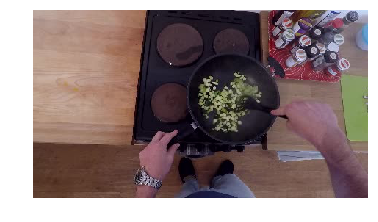

In [43]:
%matplotlib inline
I = io.imread('/vision2/u/bingbin/EPIC_KITCHENS_2018/frames_rgb_flow/rgb/train/P01/P01_01/frame_0000032030.jpg')
plt.axis('off')
plt.imshow(I)
plt.show()

In [46]:
results = model.detect([I])[0]

In [47]:
results['scores']

array([0.7972565 , 0.7579713 , 0.69126344, 0.5477416 , 0.36569878,
       0.35298553], dtype=float32)

In [92]:
print('keys are : ', results.keys())
print('class ids are : ', results['class_ids'])
print('number of rois: ', len(results['rois']))
print('roi is : ', results['rois'][5])
print('masks is : ', type(results['masks'][5]))
results['scores']

keys are :  dict_keys(['rois', 'class_ids', 'scores', 'masks', 'probs', 'c5_act', 'c5_objs'])
class ids are :  [23  2 23 14 70 91]
number of rois:  6
roi is :  [ 72 213 179 321]
masks is :  <class 'numpy.ndarray'>


array([0.7972565 , 0.7579713 , 0.69126344, 0.5477416 , 0.36569878,
       0.35298553], dtype=float32)

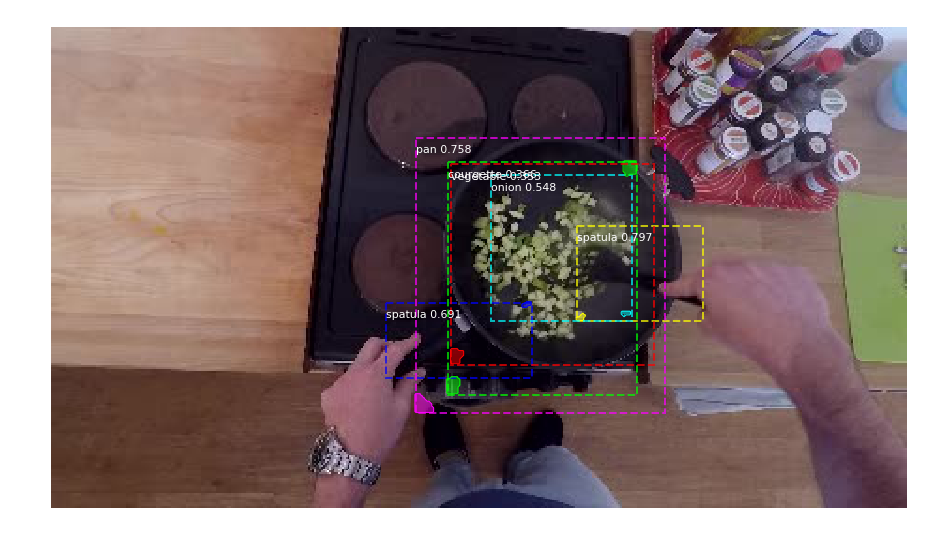

In [53]:
disp_masks = results['masks']
visualize.display_instances(I, results['rois'], disp_masks, results['class_ids'],
                                        class_names, results['scores'])

In [76]:
from collections import defaultdict

In [80]:
dd = defaultdict(list)

In [81]:
dd['1'].append(2333)

In [83]:
results['class_ids']

array([23,  2, 23, 14, 70, 91], dtype=int32)

In [93]:
len(class_names)

353

In [94]:
lllist = []

In [95]:
lllist.append([])

In [97]:
lllist

[[]]

In [103]:
xxx = pickle.load(open('P01_01_00:00:00.14_00:00:03.37.pkl', 'rb'))

In [104]:
type(xxx)

dict

In [105]:
xxx.keys()

dict_keys(['segms', 'boxes'])

In [107]:
len(xxx['segms'])

98

In [108]:
p_in = os.path.join(ORN_MASK_PATH, 'P01_01_00:00:00.14_00:00:03.37.pkl')
aaa = pickle.load(open(p_in, 'rb'))

In [109]:
len(aaa['segms'])

98

In [130]:
xxx['segms'][0][9]

[array([  0,   4, 162, 275], dtype=int32),
 array([  0, 153, 248, 432], dtype=int32)]

In [134]:
os.path.isfile(p_in+'3')

False